In [1]:
Data_path = '../data_sets/PLAID/'
%pwd
%ls $Data_path

CSV/  debug/  meta1.json  test/  train/


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
csv_path = Data_path + 'CSV/'
csv_files = os.listdir(csv_path)

In [4]:

import subprocess

def read_data_given_id(path,ids,progress=False,last_offset=0):
    '''read data given a list of ids and CSV paths'''
    n = len(ids)
    if n == 0:
        return {}
    else:
        data = {}
        for (i,ist_id) in enumerate(ids, start=1):
            if progress:
                print('%d/%d is being read...'%(i,n))
            if last_offset==0:
                data[ist_id] = np.genfromtxt(path+str(ist_id)+'.csv',
                delimiter=',',names='current,voltage',dtype=(float,float))
            else:
                p=subprocess.Popen(['tail','-'+str(int(offset)),path+
                    str(ist_id)+'.csv'],stdout=subprocess.PIPE)
                data[ist_id] = np.genfromtxt(p.stdout,delimiter=',',
                    names='current,voltage',dtype=(float,float))
        return data



In [5]:
import json

with open(Data_path + 'meta1.json') as data_file:    
    meta1 = json.load(data_file)


meta = [meta1]
meta1[0]

{u'id': u'1',
 u'meta': {u'appliance': {u'brand': u'',
   u'current': u'',
   u'manufacture_year': u'',
   u'model_number': u'',
   u'notes': u'',
   u'voltage': u'',
   u'wattage': u''},
  u'header': {u'collection_time': u'July, 2013',
   u'notes': u'some instances are not well calibrated, meta data are not complete',
   u'sampling_frequency': u'30000Hz'},
  u'instances': {u'length': u'2.00s', u'status': u'off-on'},
  u'location': u'house1',
  u'type': u'Compact Fluorescent Lamp'}}

In [6]:
def clean_meta(ist):
    '''remove '' elements in Meta Data ''' 
    clean_ist = ist.copy()
    for k,v in ist.items():
#         if 
        if len(v) == 0:
            del clean_ist[k]
    return clean_ist
                
def parse_meta(meta):
    '''parse meta data for easy access'''
    M = {}
    for m in meta:
        for app in m:
            M[int(app['id'])] = clean_meta(app['meta'])
    return M
     
Meta = parse_meta(meta)    
Meta[1000]

{u'appliance': {u'brand': u'',
  u'current': u'',
  u'manufacture_year': u'',
  u'model_number': u'',
  u'notes': u'',
  u'voltage': u'',
  u'wattage': u''},
 u'header': {u'collection_time': u'July, 2013',
  u'notes': u'some instances are not well calibrated, meta data are not complete',
  u'sampling_frequency': u'30000Hz'},
 u'instances': {u'length': u'2.00s', u'status': u'off-on'},
 u'location': u'house51',
 u'type': u'Laptop'}

In [7]:
# applinace types of all instances
Types = [x['type'] for x in Meta.values()]
# unique appliance types
unq_type = list(set(Types)) 
unq_type.sort()
print(unq_type)

# appliances
Apps = [x['meta']['type'] for x in meta1]

print('number of total instances: %d' % len(Types))
print('number of unique appliances: %d' % len(Apps))
print('number of unique appliance types: %d' % len(unq_type))

[u'Air Conditioner', u'Compact Fluorescent Lamp', u'Fan', u'Fridge', u'Hairdryer', u'Heater', u'Incandescent Light Bulb', u'Laptop', u'Microwave', u'Vacuum', u'Washing Machine']
number of total instances: 1074
number of unique appliances: 1074
number of unique appliance types: 11


In [8]:
print('%25s\t%8s' % ('Appliance Type','# instances'))
for t in unq_type:
    t_ids = [i for i,j in enumerate(Types) if j == t]
    print('%25s\t%10d' % (t,len(t_ids)))

           Appliance Type	# instances
          Air Conditioner	        66
 Compact Fluorescent Lamp	       175
                      Fan	       115
                   Fridge	        38
                Hairdryer	       156
                   Heater	        35
  Incandescent Light Bulb	       114
                   Laptop	       172
                Microwave	       139
                   Vacuum	        38
          Washing Machine	        26


In [387]:
# get 5 random instances from each type, will take ~ 1min to run
import random

count = 5
num_type = len(unq_type)
fs = 30000

ids_to_draw = {}
t_data = {}
for (ii,t) in enumerate(unq_type):
    t_ids = [i for i,j in enumerate(Types,start=1) if j == t]
    ids_to_draw[t] = random.sample(t_ids, count)
    t_data[t] = read_data_given_id(csv_path, ids_to_draw[t], False)

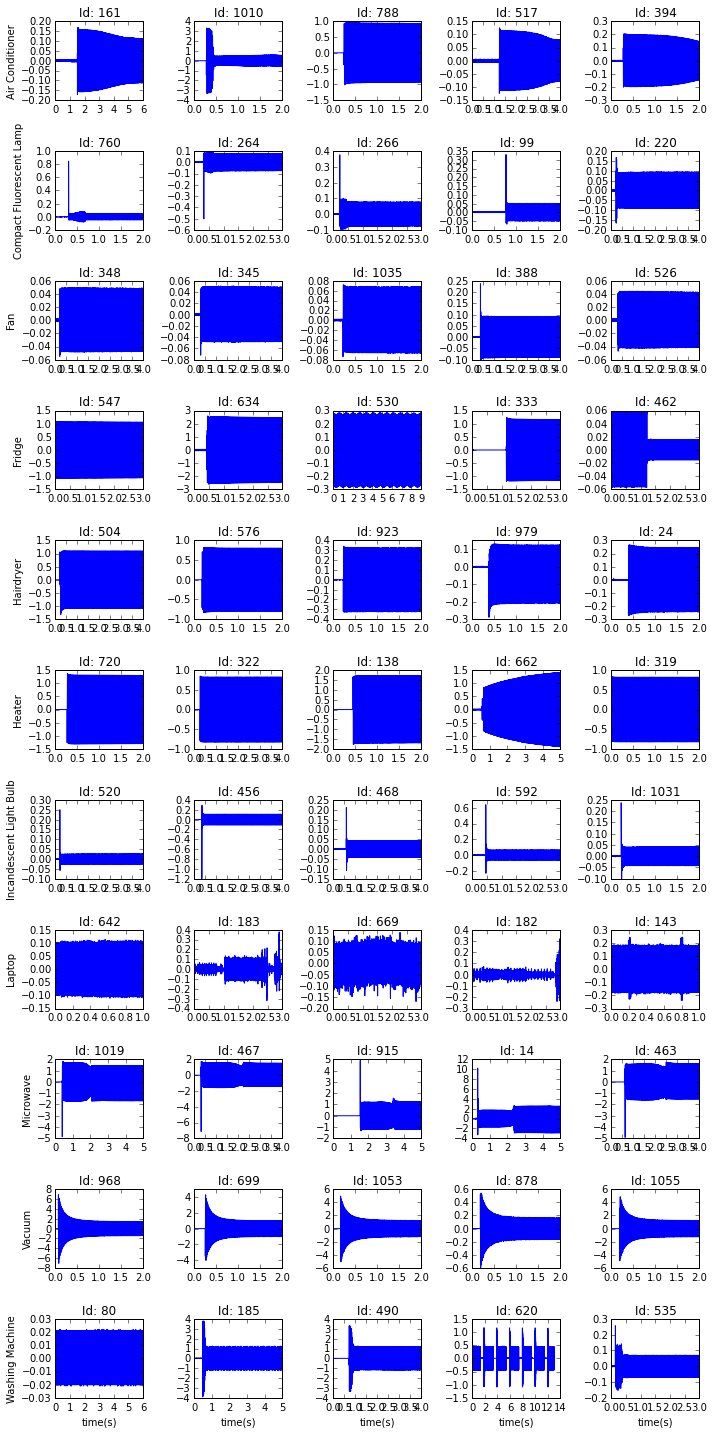

In [388]:
# plot current
fig = plt.figure(figsize=(10,20))
ids_to_draw = {}
for (ii,t) in enumerate(unq_type):
    jj = 0
    for (k,v) in t_data[t].items():
        plt.subplot(num_type,count,ii*count+jj+1)
        plt.plot(np.linspace(1./fs,len(v['current'])/fs,num=len(v['current'])),v['current'])
        #plt.plot(v['current'],v['voltage'])
        if ii==num_type-1:
            plt.xlabel('time(s)')
        if jj==0: 
            plt.ylabel(t,fontsize=10)
        plt.title('Id: '+str(k))
        jj += 1
fig.tight_layout()
plt.show()  

In [254]:
from pybrain.tools.shortcuts import buildNetwork
from pybrain.datasets import SupervisedDataSet, ClassificationDataSet
from pybrain.supervised.trainers import BackpropTrainer
import pandas as pd
import scipy.signal
import mpld3
#mpld3.enable_notebook()
from itertools import chain, izip

numHidden = 3 #number of hidden layers
numOut = 1 #num_type * 2
numInput = 13
onOffShiftParam = 10
onOffWindowSize = 2000
onOffShiftSize = onOffWindowSize / onOffShiftParam
nnWindowSize = 30000 #how many time steps are we looking at. parsing works well at 1-2k inputs and 100-200 for shift
nnShiftSize = nnWindowSize / onOffShiftParam
numOffZeros = 10000
translateParam = 0.1

Unq_type = unq_type + ['None']

on = "On"
off = "Off"
static = ""
onOffTypesList = list(chain.from_iterable(map(lambda t: [t + on, t + off],Unq_type)))
typesDict = dict(zip(Unq_type, range(len(Unq_type))))

#net = buildNetwork(numInput, numHidden, numOut)
ds = ClassificationDataSet(numInput, nb_classes=len(Unq_type), class_labels=Unq_type)
#ds = SupervisedDataSet(numInput, numOut)
#trainer = BackpropTrainer(net, ds)

In [255]:
def addOffSequence(data):
    return np.append(data, np.zeros(numOffZeros, dtype=data.dtype))
def addOnSequence(data):
    return np.append(np.zeros(numOffZeros, dtype=data.dtype), data)

def toHybridWindows(data, shiftSize, windowSize):
    for r in range(0, len(data) / shiftSize):
            yield data[r*shiftSize:windowSize + r*shiftSize]
            
def parseOutputs(windows):
    FP_THRESH = np.mean(windows, axis=0)
    diffs = []
    #Might look something like "if kpss(window) > PARAMETER: ouput = 1, else ...
    #Or something simple like (window[i] - window[i-1] / window[i] > PARAMETER then output = 1...)
    # The simple way is called the First Difference of the series
    for i, _ in enumerate(windows):
        if i > 0:
            window = np.mean(windows[i])
            past =  np.mean(windows[i-1])
            if abs(window - past) < abs(FP_THRESH[i]):
                mean_diff = 0.0
            else:
                mean_diff = window - past
            diffs.append(mean_diff)
        else:
            diffs.append(0.0)
    return diffs

Okay so we want to determine whether or not the series is stable, and label the windows appropriately for on/offs.

* Choice: Overlapping windows or distinct windows -> Hybrid
* Choice: What kind of measure should we use for staionarity?
    * Right now I'm just using the first difference method but is there a better way I should be using?
* Choice: Threshold variable for "stationary"
* Choice: Append zeroes to front and back of each signal for off signalling? Some signals don't have zeroes at the end, is that okay to leave without an off signal or should we train on something that just drops to zero without warning? (Probably \#2, should check though)

In [256]:
def windowToTotal(windows):
    global onOffShiftParam, onOffWindowSize
    tempOuts = []
    for i, window in enumerate(windows):
        if i % onOffShiftParam == 0:
            tempOuts.extend([window] * onOffWindowSize)
    return tempOuts

def parseBinOutputs(window_outputs):
    sig_start = 2.5
    sig_end = 4.0
    outMean = np.mean(window_outputs)
    outStd = np.std(window_outputs)
    numStds = 1.8
    maxStartLength = len(window_outputs) / 5
    maxEndLength = len(window_outputs) / 10
    
    out = [o if abs(o - outMean) > outMean + outStd*numStds else 0 for o in window_outputs ]
    starts = filter(lambda pair: pair[1] != 0, [(i,1) if o != 0 and i < int(len(out) / sig_start) else (i,0) for i, o in enumerate(out)])
    ends = filter(lambda pair: pair[1] != 0, [(i,-1) if o != 0 and i > len(out) - int(len(out) / sig_end) else (i,0) for i, o in enumerate(out)])
    
    if starts:
        first_start = starts[0][0]
        last_start = starts[-1][0]
        if last_start - first_start > maxStartLength:
            print "start length too large => no good start sequence found"
            last_start = first_start + maxStartLength
    else:
        first_start = -1
        last_start = -1
    if ends:
        first_end = ends[0][0]
        last_end = ends[-1][0]
        if last_end - first_end > maxEndLength:
            print "end length too large => no good end sequence found"
            last_end = first_end + maxEndLength
    else:
        first_end = -1
        last_end = -1
    
    firstOff = windowToTotal(window_outputs[:first_start-1])
    turningOn = windowToTotal(window_outputs[first_start:last_start-1])
    running = windowToTotal(window_outputs[last_start:first_end-1])
    turningOff = windowToTotal(window_outputs[first_end:last_end-1])
    finalOff = windowToTotal(window_outputs[last_end:])
    windowAll = windowToTotal(window_outputs)
    
    return first_start, last_start, first_end, last_end, windowAll

It looks like the mean diff method has a difficult time with sinusoidal signals. Also, because the signals have different frequency domains, using a single window size for all of them is difficult.

Okay!

* At this point we have some reasonably clean transition signals to go by.


* Our algorithm for marking needs to keep track of whether or not it's turned something on or off and it should only do each once for any given series. The "off" signal should come at the end of a signal, after a number of zeroes have been appended (probably 10,000). 

* Heuristically, the data I'm seeing looks like most signals have an on transition, with some starting noise in the signal, stabalize, then we turn them off abruptly. 
    * One way to turn this into a good input sequence is to set all time slots from START to END OF START as 1 (going forwards), and all signals from END to START OF END SEQUENCE to -1. 0's elsewhere
    * This strategy has a few pitfalls:
        * Any signals that turn on and off more than once during the time (or are cyclic) will be misread / trained. I'm not sure how to fix this.
        * Many signals go through a strong on phase, followed by a weaker but still existent "stabalize" phase, and we want to train the signal that for any sequence between and including those phases the appliance is turning on. 
* Let's try guessing that the signal portion within the first 1/3 of the signal duration between the first sign of "on" and the last sign of "stabilizing" will be "turning on"
     * Similar for off. Last ~12,000 turns anything with high variability will be "turning off"



In [257]:
def parseIntoSingleCycle(data):
    outMean = np.mean(data)
    outStd = np.std(data)
    cutoff = outStd
    out = [o if abs(o - outMean) > cutoff else 0 for o in data ]
    
    foundCycle = False
    startCycle = -1
    endCycle = -1
    onTolerance = 0.0001
    offTolerance = 0.0000001
    window = 1000
    
    for i, _ in enumerate(out):
        if i < window:
            continue
        if i % window == 0:
            mv_av = np.mean(map(abs,out[i-window:i]))
            #print mv_av
            if (not foundCycle) and mv_av > onTolerance:
                foundCycle = True
                startCycle = i-window
            if foundCycle and mv_av <= offTolerance:
                endCycle = i-window
                break
                
    if startCycle != -1 and endCycle == -1:
        singleCycle = data[startCycle:]
    elif startCycle != -1 and endCycle != -1:
        singleCycle = data[startCycle:endCycle]
    else:
        print "Error finding singleCycle"
        singleCycle = data
        
    return singleCycle

In [361]:
def makeWindows(base_data):
    data = abs(base_data) ** 2
    #data = base_data / np.linalg.norm(base_data)
    outMean = np.mean(data)
    outStd = np.std(data)
    
    foundCycle = False
    startCycle = -1
    endCycle = -1
    tol = outStd*1.5
    window = 15000
    totalLen = 7
    
    first_window = np.mean(map(abs,data[-1 * window:]))
    windows = []    
    for i, _ in list(enumerate(data))[::-1]:
        curr_win = data[i-window:i]
        if i < window:
            continue
        if i % window == 0:
            windows.append(curr_win)
            mv_av = np.mean(map(abs,curr_win))
            diff = abs(mv_av-first_window)
            #print mv_av
    featureVecs = map(windowToInputFeatures, windows)
    #sums = map(sum,windows[::-1])
    while len(featureVecs) < totalLen:
        if len(featureVecs) > 0:
            featureVecs.append(featureVecs[-1])
        else:
            featureVecs.append(0)
    print featureVecs
    return featureVecs

In [259]:
import cmath

def centroid(mags, freqs):
    return np.dot(mags, freqs) / np.sum(mags)

#Note: Flatness isn't actually useful because it doesn't work if any bins are 0, and our signals are very clear. 
def flatness(mags):
    denom = sum(mags) / float(len(mags))
    ans = (np.exp(sum(np.log(mags))) / float(len(mags))) / (denom)
    return ans
    

def windowToInputFeatures(window):
    featureVector = []
    N = 2
    #fft = np.fft.rfft(window)
    
    fft = np.fft.rfft(window)
    ps = abs(fft) ** 2
    time_step = 1.0 / 30000.0
    freqs = np.fft.rfftfreq(window.shape[-1], time_step)
    #idx = np.argsort(freqs)
    #plt.plot(freqs[idx], ps[idx])

    topNInd = np.argpartition(fft, -1 * N)[-1 * N:]
    topNInd.sort()
    #featureVector.extend(topNFreq)
    topNFreq = freqs[topNInd]
    topNMags = fft[topNInd]
    polars = map(cmath.polar,topNMags)
    p0 = [p[0] for p in polars]
    p1 = [p[1] for p in polars]
    #featureVector.extend( list(chain.from_iterable(sorted(izip(topNFreq, p0, p1), key=lambda x: x[1], reverse=True))))
    featureVector.extend(topNFreq)
    cent = cmath.polar(centroid(fft, freqs))
    featureVector.append(cent[0])
    featureVector.append(cent[1])
    maxi = np.nanmax(window)
    mini = np.nanmin(window)
    featureVector.append(maxi)
    featureVector.append(mini)
    w = makeWindows(window)
    featureVector.extend(w)
    #flat = flatness(ps)
    #print "flatness: " + str(flat)
    #featureVector.append(flat)
    return featureVector

#input_features is the return from windowToInputFeatures
#app_type = 'Washing Machine', etc
#action_type = 'turningOn', 'turningOff', 'static'
def inputFeaturesToFullVector(input_features, t, action_type):
    global numOut, numIn, onOffTypesList, typesDict
    final_vec = input_features
    final_vec.append(typesDict[t])
    return final_vec

- Power spectrum vs complex numbers
- flatness doesn't work
- image recognition on spectrograms perhaps?
- min/max of turning on/off (stable) might be useful features
    - intuition is "these frequences with a higher max/min => this appliance just turning on"
    - "these frequencies with a lower (stable) max/min => this appliance just turned off"

- Now we need to form the actual feature vectors (total with the oneHotEncodings for each class)
    - Done

In [260]:
def parseIntoTurningOnAndStable(base_data):
    data = base_data / np.linalg.norm(base_data)
    outMean = np.mean(data)
    outStd = np.std(data)
    
    foundCycle = False
    startCycle = -1
    endCycle = -1
    tol = outStd*1.5
    window = len(data) / 10
    
    first_window = np.mean(map(abs,v[-1 * window:]))
                      
    for i, _ in list(enumerate(v))[::-1]:
        if i < window:
            continue
        if i % window == 0:
            mv_av = np.mean(map(abs,v[i-window:i]))
            diff = abs(mv_av-first_window)
            #print mv_av
            if diff > tol:
                if (i / window) != 1:
                    return base_data[:i], base_data[i:]
                else:
                    return base_data[:i*2], base_data[i*2:]
            prev_av = mv_av
    return base_data[:window*2], base_data[window*2:]

In [360]:
ds.clear()
count = 20
training_ids = {}
testing_ids = {}
sets_of_train_ids = {}
sets_of_test_ids= {}
training_data = {}
testing_data = {}
ids_to_draw = {}
sets_of_ids = {}
t_data = {}
training_types = Unq_type
training_types = {'Microwave', 'Hairdryer'}
#training_types = {'Vacuum', 'Washing Machine', 'Microwave', 'Hairdryer'}
app = 0

for (ii,t) in enumerate(training_types):
    print "t: " + str(t)
    app_set = 0
    t_ids = [i for i,j in enumerate(Types,start=1) if j == t]
    training_ids[t] = t_ids
    sets_of_train_ids[t] = [training_ids[t][x:x+count] for x in xrange(0, len(training_ids[t]), count)]
    for train_set in sets_of_train_ids[t]:
        app_set += 1
        print "Appliance Set #" + str(app_set)
        t_data[t] = read_data_given_id(csv_path, train_set, False)
        for (k,df_v) in t_data[t].items():
            app += 1
            print "\t #" + str(app)
            v = df_v['current']
            turningOn, running = parseIntoTurningOnAndStable(v)
            np.append(running,running)
            turningOff = np.append(running, np.zeros(len(running)))
            postRun = np.random.normal(random.uniform(0,0.01),random.uniform(0,0.005),2000)

            #finalTurningOn = windowToInputFeatures(v)
            #finalRunning = windowToInputFeatures(running)
            #finalTurningOff = windowToInputFeatures(turningOff)
            #finalPostRun = windowToInputFeatures(postRun)
            #print "turningOn: " + str(finalTurningOn)
            #print "running" + str(finalRunning)
            #print "turningOff: " + str(finalTurningOff)
            #print "off: " + str(finalPostRun)
            ds.addSample(finalTurningOn,typesDict[t])
            #ds.addSample(finalRunning,typesDict['None'])
            #ds.addSample(finalTurningOff,typesDict['None'])
            #ds.addSample(finalPostRun,typesDict['None'])

            #plt.plot(v)
            #plt.show()
            #plt.plot(turningOn)
            #plt.show()
            #plt.plot(running)
            #plt.show()
print "Done"

t: Hairdryer
Appliance Set #1


KeyboardInterrupt: 

In [355]:
print len(ds.getField('target'))
tstdata, trndata = ds.splitWithProportion( 0 )
trndata._convertToOneOfMany( )
tstdata._convertToOneOfMany( )

1074


In [356]:
print "Number of training patterns: ", len(trndata)
print "Number of testing patterns: ", len(tstdata)
print "Input and output dimensions: ", trndata.indim, trndata.outdim
print "First sample (input, target, class):"
print trndata['input'][0], trndata['target'][0], trndata['class'][0]
print trndata['input'][-1], trndata['target'][-1], trndata['class'][-1]
print trndata.calculateStatistics()

Number of training patterns:  1074
Number of testing patterns:  0
Input and output dimensions:  13 12
First sample (input, target, class):
[  5.97527473e+01   6.01648352e+01   2.86406535e+03   8.42470819e-01
   2.21000000e-01  -1.71000000e-01   1.47540000e-02   1.52460000e-02
   1.51290000e-02   1.77830000e-02   1.97130000e-02   1.99030000e-02
   4.57482720e+01] [1 0 0 0 0 0 0 0 0 0 0 0] [ 0.]
[  5.60000000e+01   1.80000000e+02   1.18539962e+03   7.06055764e-01
   1.01200000e+00  -1.00500000e+00   2.05452954e+03   1.96440395e+03
   2.05189514e+03   2.05827090e+03   1.95862477e+03   2.03820862e+03
   2.07559598e+03] [0 0 0 0 0 0 0 0 0 0 1 0] [ 10.]
{0: 66, 1: 175, 2: 115, 3: 38, 4: 156, 5: 35, 6: 114, 7: 172, 8: 139, 9: 38, 10: 26, 11: 0}


In [357]:
from pybrain.structure.modules import SoftmaxLayer
from pybrain.utilities import percentError
fnn = buildNetwork( trndata.indim, 20, trndata.outdim, outclass=SoftmaxLayer)
trainer = BackpropTrainer( fnn, dataset=trndata, verbose=True,  learningrate=0.0001)# momentum=0.05, weightdecay=0.005) 

In [294]:
for i in range(15):
    trainer.trainEpochs( 10 )
    #trainer.trainUntilConvergence(maxEpochs=30)
    testedData = trainer.testOnClassData()
    print testedData
    testedData = trainer.testOnClassData(dataset=tstdata)
    print testedData
    print trndata['input'][0], trndata['input'][-1]
    print 
    test1 = fnn.activate(trndata['input'][0])
    test2 = fnn.activate(trndata['input'][-1])
    print test1, test2
    
    trnresult = percentError( trainer.testOnClassData(dataset=trndata), 
                              trndata['class'] )
    tstsresult = 0.0
    tstresult = percentError( trainer.testOnClassData(
           dataset=tstdata ), tstdata['class'] )
    print 
    print "epoch: %4d" % trainer.totalepochs, \
          "  train error: %5.2f%%" % trnresult, \
          "  test error: %5.2f%%" % tstresult
    print

Total error: 0.03705743511
Total error: 0.0369959570111
Total error: 0.0369388892456
Total error: 0.0368841691774
Total error: 0.0368242257714
Total error: 0.0367809018464
Total error: 0.0367313338484
Total error: 0.036677337154
Total error: 0.0366361009396
Total error: 0.0365890856421
[7, 7, 7, 7, 7, 1, 1, 0, 1, 7, 7, 1, 8, 1, 8, 7, 1, 7, 7, 7, 1, 8, 8, 7, 8, 7, 7, 4, 11, 8, 7, 1, 1, 7, 4, 7, 7, 7, 7, 11, 11, 11, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 4, 7, 7, 7, 7, 7, 7, 7, 7, 7, 1, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 4, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 4, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 

To resolve between appliance types and within appliance types we might want to use a different type of signal windowing. [here](https://en.wikipedia.org/wiki/Spectral_leakage) Extra features then?

Might work to just take the top 10 or so frequencies from  FFT and just run on that? Looks like different signals have different frequency distributions. 

Also taking the mean amplitudes of things into account (heater vs lightbulb)

Learn more about features from [here](https://dsp.stackexchange.com/questions/16870/feature-extraction-from-spectrum-to-aid-categorisation/16873#16873). Looks like a really useful list of things to account for, in addition to major frequencies.

Looks like even with all of the above it's just not doing well. Still ~82% error over all signal sets, and ~25% 

Todo:

- Heatmap for features of appliances
- Learning rate / NN parameters


13
Air Conditioner
66

66
Compact Fluorescent Lamp
241

241
Fan
356

356
Fridge
394

394
Hairdryer
550

550
Heater
585

585
Incandescent Light Bulb
699

699
Laptop
871

871
Microwave
1010

1010
Vacuum
1048

1048
Washing Machine
1074

1074
None

0-1: top 2 freqs
2-3 centroid polars
4-5: min/max of pure signal
6-12: power of turning on signal split by 500ms intervals
13: the class


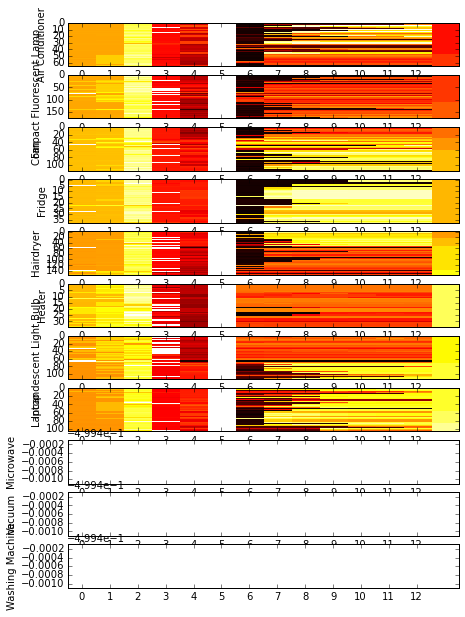

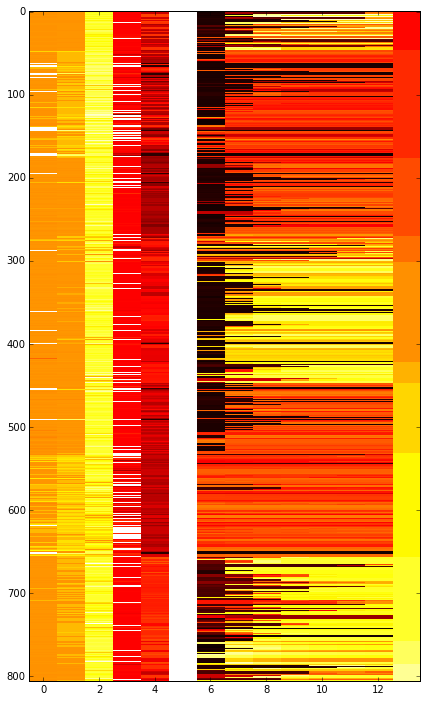

In [333]:
basic_data = []
col_sums = trndata['input'].sum(axis=0)
norm_trndata = trndata['input']
print len(norm_trndata[0])
#norm_trndata =  trndata['input'] / col_sums[np.newaxis, :]
norm_trndata = pd.DataFrame(trndata['input'])
norm_trndata = np.log(norm_trndata)
norm_trndata = pd.concat([norm_trndata.transpose(), pd.DataFrame(trndata['class']).transpose()]).transpose()
#print norm_trndata
#print norm_trndata[[0,1,2,3,4,5]]
cols = [0,1,2,3,4,5]
basic_data = norm_trndata

fig = plt.figure( figsize=(7,12))
curr = 0
prev_curr = 0
for i, t in enumerate(training_types):
    print t
    curr += len(training_ids[t])
    if curr == prev_curr:
        break
    print curr
    print
    sp = fig.add_subplot(len(training_types)+1, 1, i+1)
    sp.imshow(basic_data[prev_curr:curr], cmap='hot', interpolation='nearest', aspect="auto")
    sp.set_ylabel(t)
    sp.set_xticks(np.arange(13))
    #plot([curr]*len(basic_data[200]), color="black")
    prev_curr = curr
    print prev_curr

#sp2.set_yticks(range(len(training_types)))
#sp2.set_yticklabels([app for app in unq_type], fontsize=10)
fig.show()
#fig.savefig("individual_heatmaps_powers.png")

fig = plt.figure( figsize=(7,12))
plt.imshow(basic_data, cmap='hot', interpolation='nearest', aspect="auto")
fig.show()
#fig.savefig("overall_heatmaps_powers.png")
print
print "0-1: top 2 freqs"
print "2-3 centroid polars"
print "4-5: min/max of pure signal"
print "6-12: power of turning on signal split by 500ms intervals"
print "13: the class"


In [324]:
mpld3.disable_notebook()
from itertools import combinations
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

In [384]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    global Unq_type
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(Unq_type))
    plt.xticks(tick_marks,Unq_type, rotation=90)
    plt.yticks(tick_marks, Unq_type)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

(Right) Mask: ()
Number of mislabeled points out of a total 1074 points : 400
0.627560521415
Confusion matrix, without normalization
[[ 18   1  31   1   6   0   0   1   2   4   2]
 [  0 126  11   1   0   0  30   6   1   0   0]
 [  0   5 102   2   3   0   1   2   0   0   0]
 [  4   5   3   8  11   3   2   2   0   0   0]
 [ 20  11   4  11 106   0   0   0   4   0   0]
 [  3   3   0   1   7  17   0   0   3   1   0]
 [  0  12  45   0   0   0  52   5   0   0   0]
 [  0   8  14   0   0   0  29 121   0   0   0]
 [  0  16   0   9   2   3   0   0 102   7   0]
 [  1   0   0   1  13   0   0   0   1  22   0]
 [ 10   3   7   0   5   1   0   0   0   0   0]]
(Right) Mask: (0,)
Number of mislabeled points out of a total 1074 points : 379
0.647113594041
Confusion matrix, without normalization
[[ 20   1  30   1   6   0   0   2   2   2   2]
 [  0 136  16   0   0   0   6  15   2   0   0]
 [  0   8  97   2   3   0   1   4   0   0   0]
 [  4   5   3  10   9   3   0   4   0   0   0]
 [ 20  11   5  10 106   0 

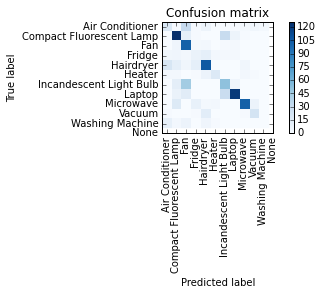

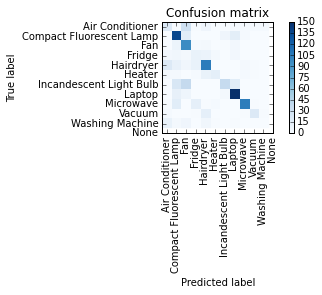

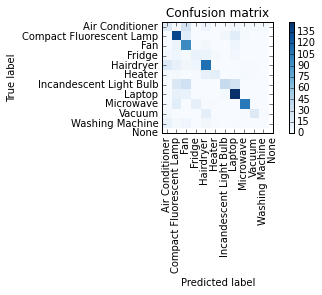

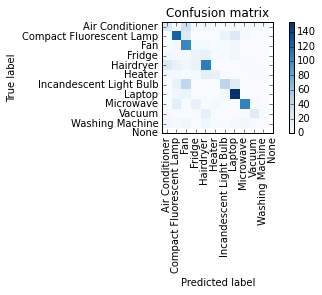

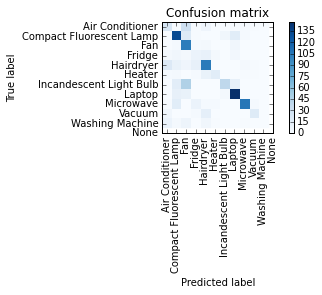

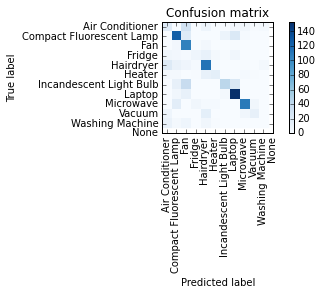

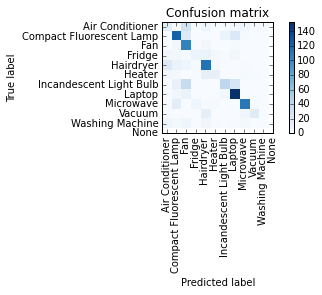

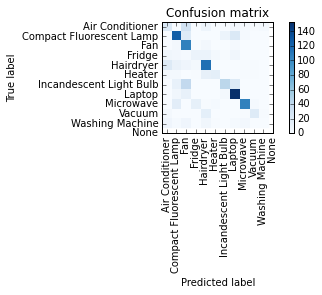

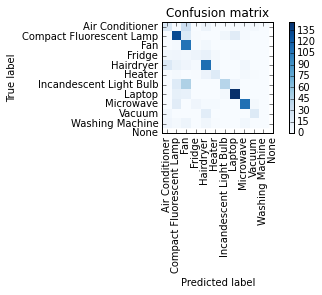

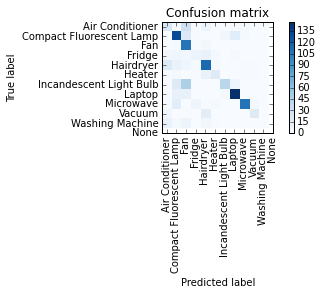

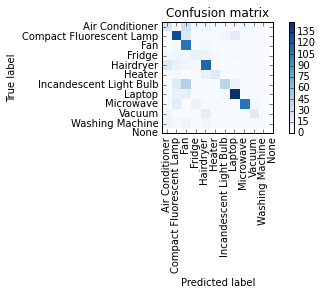

In [390]:
from sklearn.naive_bayes import GaussianNB
from sklearn import svm, linear_model, metrics
from sklearn.metrics import confusion_matrix

masks = powerset(range(12))
#mask = [4]
#best_auc = 0 - AUC not helpful for multiclass unless we do some actula analysis
max_right = 0
best_mask = []
for i, mask in enumerate(masks):
    X = np.delete(trndata['input'], mask, 1)
    y = trndata['class']
    tstX = np.delete(tstdata['input'], mask, 1)
    tstY = tstdata['class']
    #tstX = np.append(X, tstX)
    #tstY = np.append(y, tstY)
    tstX = X
    tstY = y
    gnb = GaussianNB()
    y_fit = gnb.fit(X, y.ravel())
    y_pred = y_fit.predict(tstX)

    #fpr, tpr, thresholds = metrics.roc_curve(tstY, y_pred, pos_label=2)
    #auc = metrics.auc(fpr, tpr)
    right = [1 for i, _ in enumerate(y_pred) if y_pred[i] == tstY[i]]
    if sum(right) >= max_right:
        max_right  = sum(right)
        print "(Right) Mask: " + str(mask)
        best_mask = mask
        #print y_pred
        print("Number of mislabeled points out of a total %d points : %d"
              % (tstX.shape[0],len(y_pred) - sum(right)))
        print float(sum(right)) / float(len(y_pred))
        
        cm = confusion_matrix(tstY, y_pred)
        np.set_printoptions(precision=2)
        print('Confusion matrix, without normalization')
        print(cm)
        plt.figure()
        plot_confusion_matrix(cm)
    
plt.savefig("conf_matrix" + str(i) + ".png")
print "Done"

In [366]:
X = np.delete(trndata['input'], best_mask, 1)
y = trndata['class']
tstX = np.delete(tstdata['input'], best_mask, 1)
tstY = tstdata['class']
gnb = GaussianNB()
y_fit = gnb.fit(X, y.ravel())
y_pred = y_fit.predict(tstX)
cm = confusion_matrix(tstY, y_pred)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)


ValueError: Found array with 0 sample(s) (shape=(0, 13)) while a minimum of 1 is required.

In [351]:

mask = []
X = np.delete(trndata['input'], mask, 1)
y = trndata['class']
tstX = np.delete(tstdata['input'], mask, 1)
tstY = tstdata['class']
#clf = svm.LinearSVC()
print clf.fit(X, y.ravel()) 
svm_y_pred = clf.predict(tstX)
svm_right = [1 for i, _ in enumerate(svm_y_pred) if svm_y_pred[i] == tstY[i]]
print svm_y_pred
print("Number of mislabeled points out of a total %d points : %d"
      % (tstX.shape[0],len(svm_y_pred) - sum(svm_right)))
#print svm_right

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
[  2.   2.   2.   4.   3.   8.  10.   2.   7.   2.   8.   8.   1.   2.   2.
   1.   4.   2.   2.   2.   2.   1.   1.   1.   1.   7.   1.   1.   1.   1.
   2.   1.   1.   1.   2.   1.   1.   1.   2.   1.   1.   1.   2.   7.   2.
   1.   1.   2.   2.   1.   1.   1.   2.   1.   2.   1.   1.   1.   1.   1.
   2.   7.   2.   2.   1.   1.   2.   2.   2.   2.   2.   2.   2.   2.   2.
   2.   2.   2.   2.   2.   8.   2.   2.   2.   4.   7.   1.   3.   2.   2.
   8.   0.   4.   0.   2.   0.   8.   3.   2.   8.   2.   6.   0.   0.   2.
   0.   8.  10.   0.   3.   4.   0.   2.   2.   4.   4.   4.   2.   4.   0.
   2.   8.   2.   2.   2.   2.   4.   4.   1.   3.   0.   0.   0.   3.   4.
   4.   0.   2.   2.   2.   2.   2.   6.   2.   1.   1.   2.   2.   2.   2.
   2.   2.   2.   2.   2.

In [354]:
logreg = linear_model.LogisticRegression(C=1e5)

logreg.fit(X, y)

lr_pred = logreg.predict(tstX)
lr_right = [1 for i, _ in enumerate(lr_pred) if lr_pred[i] == tstY[i]]

fpr, tpr, thresholds = metrics.roc_curve(tstY, lr_pred, pos_label=2)
print metrics.auc(fpr, tpr)
#print svm_y_pred
print("Number of mislabeled points out of a total %d points : %d"
      % (tstX.shape[0],len(lr_pred) - sum(svm_right)))

/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.284364758049
Number of mislabeled points out of a total 268 points : 172
0.284364758049
Number of mislabeled points out of a total 268 points : 172
0.284364758049

/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Number of mislabeled points out of a total 268 points : 172
0.284364758049
Number of mislabeled points out of a total 268 points : 172
0.284364758049

/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Number of mislabeled points out of a total 268 points : 172
0.284364758049
Number of mislabeled points out of a total 268 points : 172
0.284364758049

/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Number of mislabeled points out of a total 268 points : 172
0.284364758049
Number of mislabeled points out of a total 268 points : 172
0.284364758049

/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Number of mislabeled points out of a total 268 points : 172
0.284364758049
Number of mislabeled points out of a total 268 points : 172


In [ ]:
fullNoOffDataSet


In [ ]:
fullWithOffDataSet


Could we just use image recogniiton on the current signals themselves and run with that? They're very visually different, but I don't know how that translated into signal features.

Is there a way (and would it work) that we could normalize the signals themselves to all fall within some bounds

In [110]:
wm = read_data_given_id(csv_path, [training_ids['Microwave'][0]], False)
for (k,df_v) in wm.items():
    wmc = df_v['current']

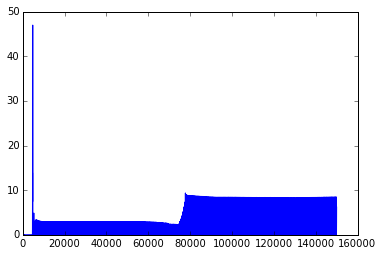

In [151]:
plt.plot(abs(wmc)**2)


[10563.832793999889, 9756.4897610000262, 9740.7698479999654, 9718.4833650000401, 10125.660208000054, 31466.741022000115, 34163.754260999813, 34250.95349199995, 34231.17626099995]


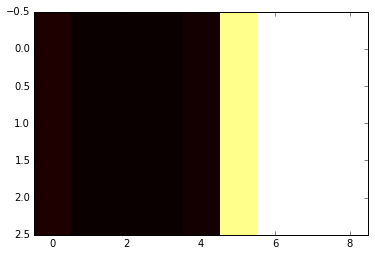

In [177]:
w = makeWindows(wmc)
print w
ws = []
for i in range(3):
    ws.append(w)
ws = np.array(ws)
plt.imshow(ws, cmap='hot', interpolation='nearest', aspect="auto")

- Time domain features more
- Envelope
- fitting quadratics to eht curves
- how does the physical model affect it?
- integrate power over ~500ms intervals. first 500ms how much power does it use?